# Safe Browsing for Kids Under Parental Supervision Using Machine Learning

This notebook contains the implementation of a safe browsing system for kids using machine learning for URL classification and deep learning for image detection.

## 1. Introduction
### Problem Statement
Children in the 21st century have easy access to the internet, but not all content is suitable for them. Exposure to inappropriate content can negatively impact their development. This project aims to provide a safe browsing environment for kids using machine learning and deep learning techniques.

### Objectives
- Classify URLs as safe or unsafe using supervised machine learning.
- Detect inappropriate images using deep learning.
- Provide parental controls with customizable settings for different age groups.

### Key Features
1. Parental control settings for different age groups.
2. Real-time URL classification using ensemble ML models.
3. Image content detection using deep learning.
4. Detailed activity logging and reporting.
5. Customizable risk thresholds for different age groups.

## 2. Data Collection and Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
import joblib
import os
from urllib.parse import urlparse
import datetime
from dataset import generate_dataset, extract_url_features

# Set style for plots
plt.style.use('seaborn')
sns.set_palette('husl')

In [2]:
def balance_dataset(X, y):
    """Balance dataset using upsampling for minority class"""
    X_df = pd.DataFrame(X)
    X_df['target'] = y

    # Separate majority and minority classes
    majority = X_df[X_df.target == 0]
    minority = X_df[X_df.target == 1]

    # Upsample minority class
    minority_upsampled = resample(minority,
                                  replace=True,
                                  n_samples=len(majority),
                                  random_state=42)

    # Combine majority class with upsampled minority class
    df_balanced = pd.concat([majority, minority_upsampled])

    # Separate features and target
    y_balanced = df_balanced.target
    X_balanced = df_balanced.drop('target', axis=1)

    return X_balanced.values, y_balanced.values

In [3]:
# Generate dataset
print("Generating dataset...")
dataset = generate_dataset()

# Extract features and labels
feature_columns = [col for col in dataset.columns if col not in ['url', 'is_blocked', 'category']]
X = dataset[feature_columns].values
y = dataset['is_blocked'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Balance training data
X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

2025-01-26 15:28:30,609 - INFO - Processing 981 URLs...


Generating dataset...


Processing URLs:   0%|          | 0/981 [00:00<?, ?it/s]2025-01-26 15:28:36,596 - WARNING - Could not get domain age for www.codingninjas.com: [Errno 104] Connection reset by peer
2025-01-26 15:28:36,601 - WARNING - Could not get domain age for f95zone.to: [Errno 104] Connection reset by peer
Processing URLs:   1%|          | 5/981 [00:11<36:31,  2.25s/it]2025-01-26 15:28:43,984 - WARNING - Could not get domain age for csgorocket.com: No match for "CSGOROCKET.COM".
>>> Last update of whois database: 2025-01-26T09:58:22Z <<<

NOTICE: The expiration date displayed in this record is the date the
registrar's sponsorship of the domain name registration in the registry is
currently set to expire. This date does not necessarily reflect the expiration
date of the domain name registrant's agreement with the sponsoring
registrar.  Users may consult the sponsoring registrar's Whois database to
view the registrar's reported date of expiration for this registration.

TERMS OF USE: You are not autho

## 3. URL Classification Using Machine Learning

In [4]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model and plot metrics"""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0)
    }
    
    # Plot metrics
    plt.figure(figsize=(10, 5))
    plt.bar(metrics.keys(), metrics.values())
    plt.title(f'Performance Metrics - {model_name}')
    plt.ylim(0, 1)
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    plt.show()
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, model_name)
    
    return metrics


Training KNN model...

KNN Model Performance:


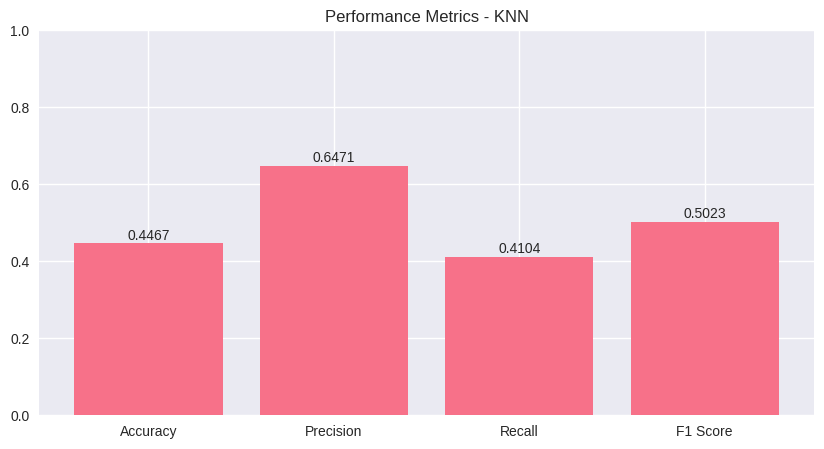

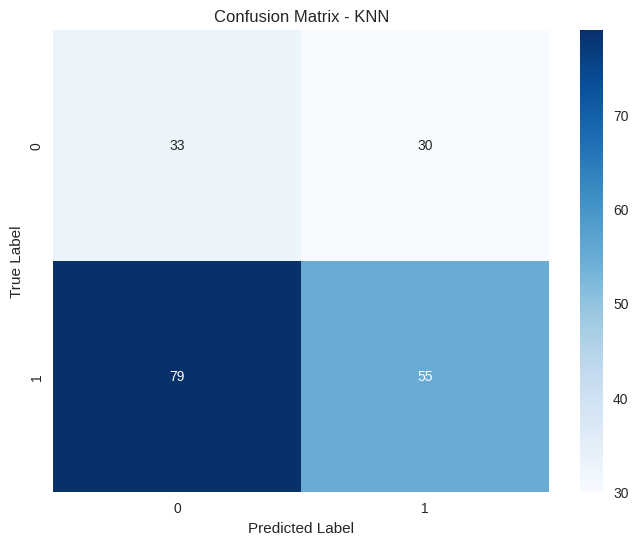


Training SVM model...

SVM Model Performance:


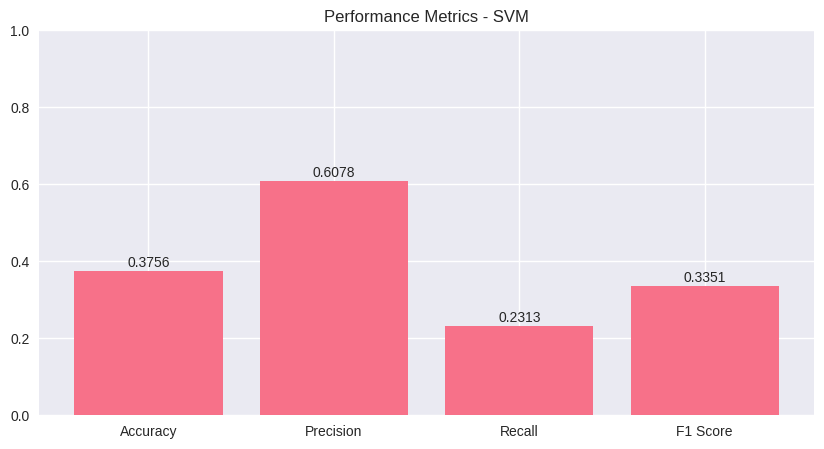

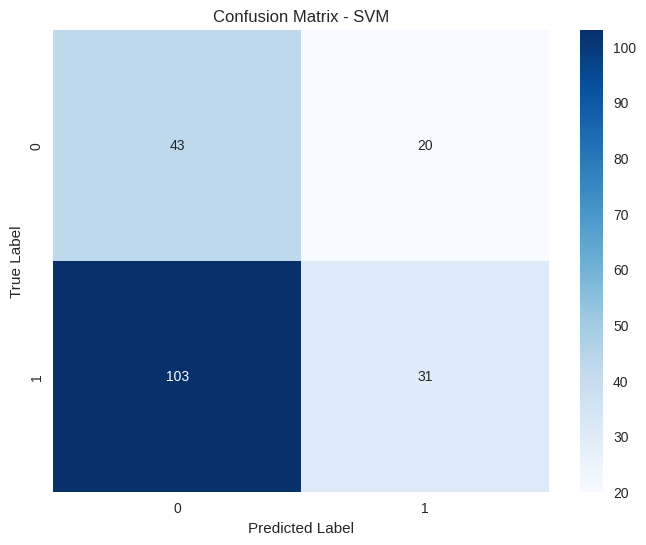


Training Naive Bayes model...

Naive Bayes Model Performance:


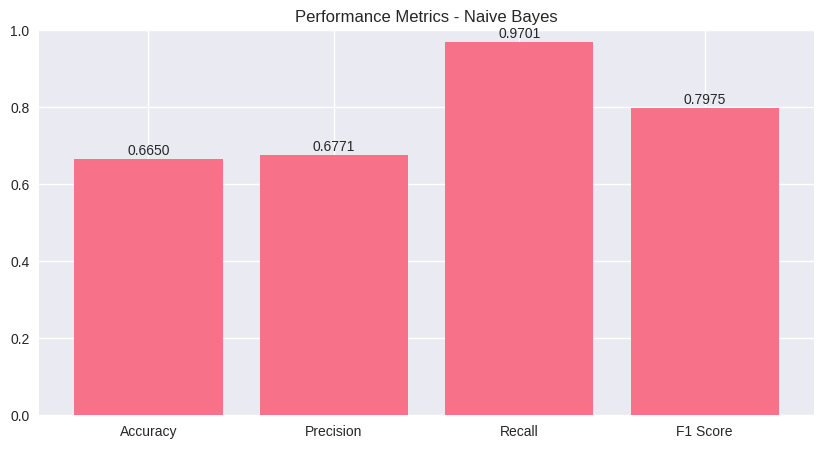

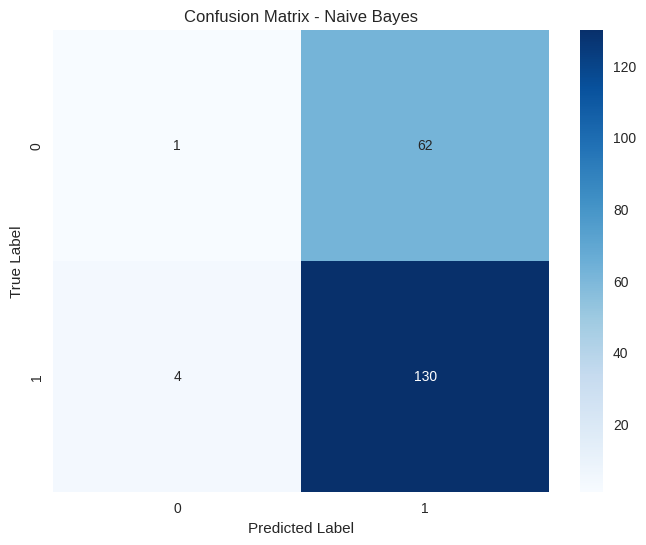

In [5]:
# Initialize and train models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'SVM': SVC(kernel='rbf', probability=True, C=1.0),
    'Naive Bayes': GaussianNB()
}

trained_models = {}
model_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    model.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    model_predictions[name] = y_pred
    
    # Evaluate and plot
    print(f"\n{name} Model Performance:")
    metrics = evaluate_model(y_test, y_pred, name)
    
    trained_models[name] = model

## 4. Image Content Detection Using Deep Learning

In [6]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
        
        self.classes = ['safe', 'unsafe']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def load_dataset(data_dir):
    return ImageDataset(data_dir)

# Define image classifier
class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in self.model.parameters():
            param.requires_grad = False
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "train_loss"}}

# Train image classifier
def train_image_classifier(train_data_dir, val_data_dir=None):
    train_dataset = load_dataset(train_data_dir)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = None
    if val_data_dir:
        val_dataset = load_dataset(val_data_dir)
        val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)
    model = ImageClassifier()
    trainer = pl.Trainer(max_epochs=20, accelerator='auto', devices=1)
    trainer.fit(model, train_loader, val_loader)
    return model

## 5. Parental Control Features

In [7]:
# Age group-based risk thresholds
age_thresholds = {
    'kid': 0.5,
    'teen': 0.6,
    'adult': 0.7
}

# Real-time URL and image blocking
def predict_url(url, age_group='kid'):
    features = extract_url_features(url)
    features_array = np.array(list(features.values())).reshape(1, -1)
    features_scaled = scaler.transform(features_array)
    probabilities = {}
    for name, model in trained_models.items():
        probabilities[name] = model.predict_proba(features_scaled)[0][1]
    final_risk_score = np.mean(list(probabilities.values()))
    risk_level = 'High' if final_risk_score > age_thresholds[age_group] else 'Low'
    return risk_level, final_risk_score

# Activity logging
activity_log = []

def log_activity(url, risk_level, age_group):
    activity_log.append({
        'URL': url,
        'Risk Level': risk_level,
        'Age Group': age_group,
        'Time': datetime.datetime.now().strftime("%b %d, %Y, %I:%M %p")
    })

## 6. Save Models

In [8]:
# Save models and preprocessing objects
save_dir = 'models/latest'
os.makedirs(save_dir, exist_ok=True)

for name, model in trained_models.items():
    filename = name.lower().replace(' ', '_')
    joblib.dump(model, os.path.join(save_dir, f'{filename}_model.pkl'))

# Save scaler and feature columns
joblib.dump(scaler, os.path.join(save_dir, 'url_scaler.pkl'))
joblib.dump(feature_columns, os.path.join(save_dir, 'feature_cols.pkl'))

print("Models saved successfully!")

Models saved successfully!


## 7. Model Comparison

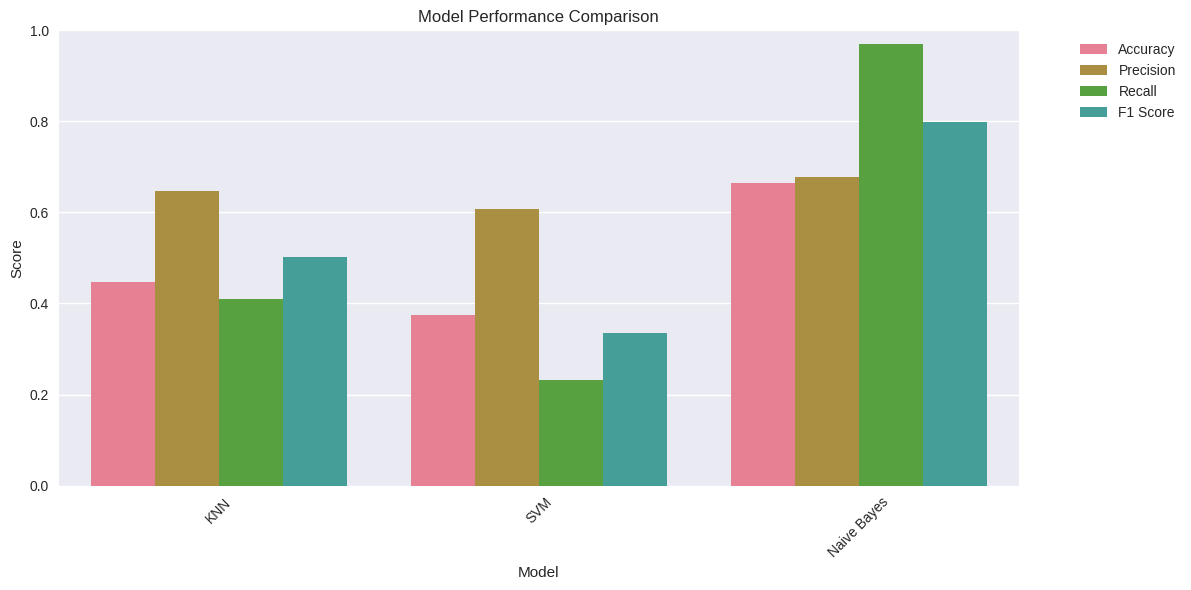

In [9]:
# Compare model performance
metrics_df = pd.DataFrame()

# Use trained_models instead of models since it contains the actual trained models
for name in trained_models.keys():
    y_pred = model_predictions[name]
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)

# Plot comparison
metrics_melted = pd.melt(metrics_df, 
                        id_vars=['Model'], 
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                        var_name='Metric', 
                        value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 8. Test URL Classification with Visualizations


Testing URL: https://www.wikipedia.org/wiki/Machine_learning


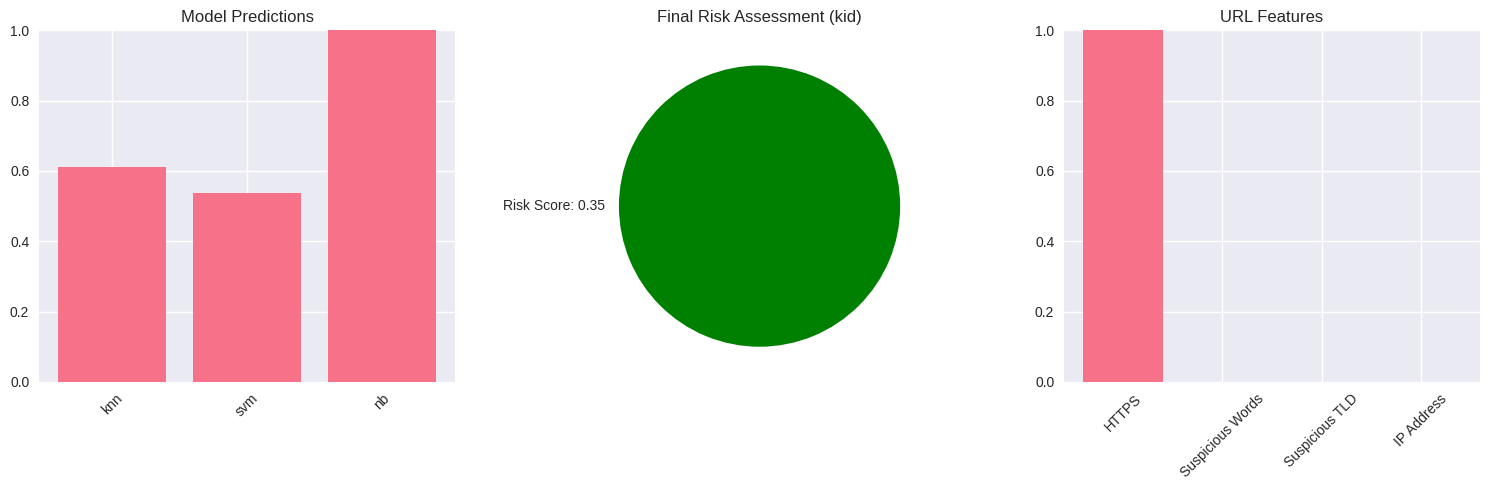

Is Unsafe: False
Probability: 0.3500
Risk Score: 0.3500
----------------------------------------

Testing URL: https://www.python.org/downloads/


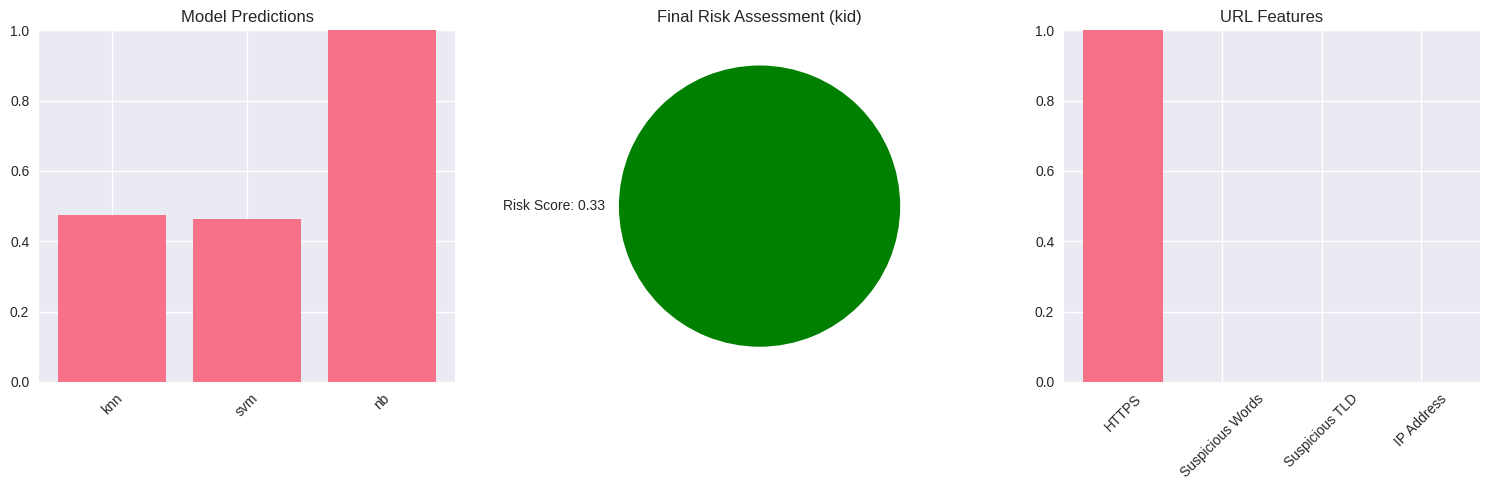

Is Unsafe: False
Probability: 0.3296
Risk Score: 0.3296
----------------------------------------

Testing URL: https://github.com/features


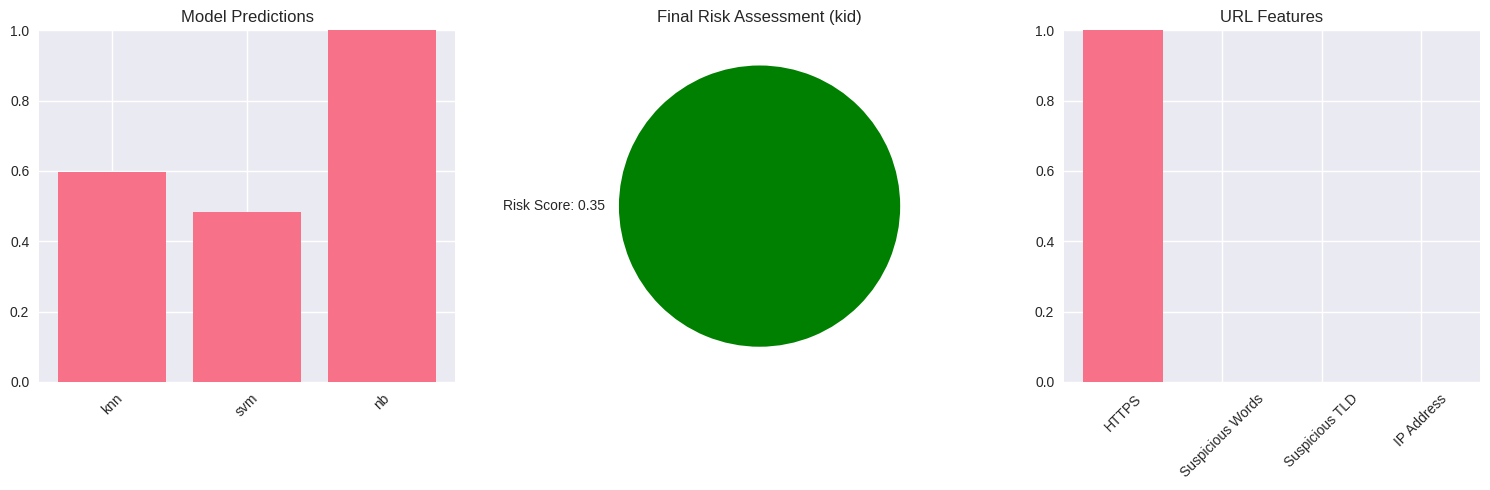

Is Unsafe: False
Probability: 0.3500
Risk Score: 0.3500
----------------------------------------

Testing URL: http://suspicious-site.xyz/download.exe


2025-01-26 15:47:51,460 - WARNING - Could not get page content for http://suspicious-site.xyz/download.exe: HTTPConnectionPool(host='suspicious-site.xyz', port=80): Max retries exceeded with url: /download.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7c6920717c70>: Failed to resolve 'suspicious-site.xyz' ([Errno -2] Name or service not known)"))
2025-01-26 15:47:56,050 - WARNING - Could not get page content for http://suspicious-site.xyz/download.exe: HTTPConnectionPool(host='suspicious-site.xyz', port=80): Max retries exceeded with url: /download.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7c6920720250>: Failed to resolve 'suspicious-site.xyz' ([Errno -2] Name or service not known)"))
2025-01-26 15:47:57,190 - WARNING - Could not get page content for http://suspicious-site.xyz/download.exe: HTTPConnectionPool(host='suspicious-site.xyz', port=80): Max retries exceeded with url: /download.exe (Caused by NameRes

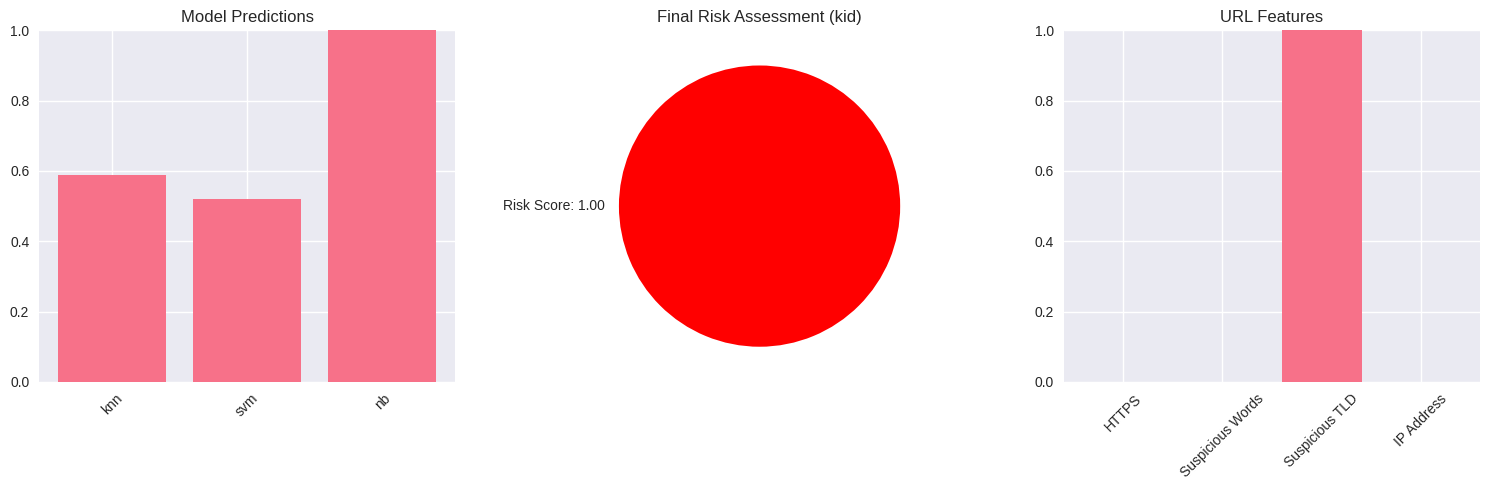

Is Unsafe: True
Probability: 1.0000
Risk Score: 1.0000
----------------------------------------

Testing URL: http://192.168.1.1/admin/hack.php


2025-01-26 15:48:08,341 - WARNING - Could not get page content for http://192.168.1.1/admin/hack.php: HTTPConnectionPool(host='192.168.1.1', port=80): Max retries exceeded with url: /admin/hack.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7c69207fbf70>, 'Connection to 192.168.1.1 timed out. (connect timeout=10)'))
2025-01-26 15:48:19,115 - WARNING - Could not get page content for http://192.168.1.1/admin/hack.php: HTTPConnectionPool(host='192.168.1.1', port=80): Max retries exceeded with url: /admin/hack.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7c6920720490>, 'Connection to 192.168.1.1 timed out. (connect timeout=10)'))
2025-01-26 15:48:29,680 - WARNING - Could not get page content for http://192.168.1.1/admin/hack.php: HTTPConnectionPool(host='192.168.1.1', port=80): Max retries exceeded with url: /admin/hack.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7c692d534be0>, 'Co

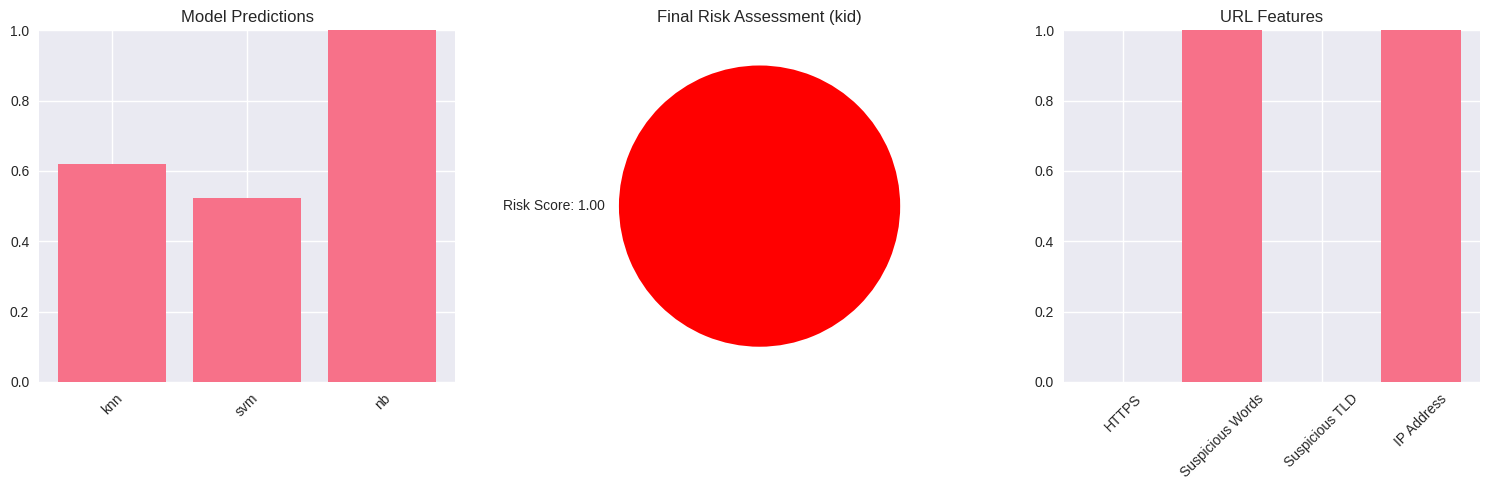

Is Unsafe: True
Probability: 1.0000
Risk Score: 1.0000
----------------------------------------

Testing URL: http://free-casino-games.tk/poker


2025-01-26 15:48:44,889 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-01-26 15:48:44,889 - ERROR - Error trying to connect to socket: closing socket - timed out
2025-01-26 15:48:48,098 - WARNING - Could not get page content for http://free-casino-games.tk/poker: HTTPConnectionPool(host='free-casino-games.tk', port=80): Max retries exceeded with url: /poker (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7c692d534640>: Failed to resolve 'free-casino-games.tk' ([Errno -2] Name or service not known)"))
2025-01-26 15:48:58,857 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-01-26 15:48:58,857 - ERROR - Error trying to connect to socket: closing socket - timed out
2025-01-26 15:48:59,950 - WARNING - Could not get page content for http://free-casino-games.tk/poker: HTTPConnectionPool(host='free-casino-games.tk', port=80): Max retries exceeded with url: /poker (Caused by Name

In [ ]:
def calculate_age_based_risk(predictions, features, age_group='kid'):
    """Calculate risk level and score based on age group and features"""
    # Base weights for different models based on their performance
    model_weights = {
        'knn': 0.3,
        'svm': 0.4,
        'nb': 0.3
    }

    # Calculate weighted average of model predictions
    weighted_score = sum(pred['probability'] * model_weights[model] 
                        for model, pred in predictions.items())

    # Age-specific risk modifiers
    age_risk_multipliers = {
        'kid': 1.5,    # More strict for kids
        'teen': 1.2,   # Moderately strict for teens
        'adult': 1.0   # Base level for adults
    }

    # Apply age-specific risk multiplier
    risk_score = min(1.0, weighted_score * age_risk_multipliers.get(age_group, 1.0))

    # Determine risk level
    if risk_score > 0.8:
        risk_level = 'high'
    elif risk_score > 0.5:
        risk_level = 'medium'
    else:
        risk_level = 'low'

    return risk_level, risk_score

def predict_url(url, threshold=0.65, models_dir=None, age_group='kid'):
    """Make prediction for a single URL using ensemble of models"""
    if models_dir is None:
        models_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'models', 'latest')

    # Load models and scaler
    knn = joblib.load(os.path.join(models_dir, 'knn_model.pkl'))
    svm = joblib.load(os.path.join(models_dir, 'svm_model.pkl'))
    nb = joblib.load(os.path.join(models_dir, 'naive_bayes_model.pkl'))
    scaler = joblib.load(os.path.join(models_dir, 'url_scaler.pkl'))
    feature_cols = joblib.load(os.path.join(models_dir, 'feature_cols.pkl'))

    # Extract and prepare features
    features = extract_url_features(url)
    if isinstance(features, dict):
        features = list(features.values())
    features_array = np.array(features).reshape(1, -1)
    features_scaled = scaler.transform(features_array)

    # Get predictions
    predictions = {}
    probas = []

    # KNN
    knn_prob = knn.predict_proba(features_scaled)[0][1]
    predictions['knn'] = {
        'prediction': knn_prob > threshold,
        'probability': knn_prob
    }
    probas.append(knn_prob)

    # SVM
    svm_prob = svm.predict_proba(features_scaled)[0][1]
    predictions['svm'] = {
        'prediction': svm_prob > threshold,
        'probability': svm_prob
    }
    probas.append(svm_prob)

    # Naive Bayes
    nb_prob = nb.predict_proba(features_scaled)[0][1]
    predictions['nb'] = {
        'prediction': nb_prob > threshold,
        'probability': nb_prob
    }
    probas.append(nb_prob)

    # Calculate base risk from model predictions
    base_features = extract_url_features(url) if isinstance(url, str) else dict(zip(feature_cols, features))

    # Trust factors (reduce risk score)
    trust_score = 1.0
    if base_features.get('has_https', 0) == 1:
        trust_score *= 0.7  # Significant trust for HTTPS

    # Check for trusted domains
    domain = urlparse(url).netloc.lower()
    trusted_domains = {'github.com', 'python.org', 'wikipedia.org'}
    if any(td in domain for td in trusted_domains):
        trust_score *= 0.5  # High trust for known good domains

    # Risk factors (increase risk score)
    risk_multiplier = 1.0
    if base_features.get('is_ip_address', 0) == 1:
        risk_multiplier *= 2.0  # Major increase for IP-based URLs
    if base_features.get('suspicious_word_count', 0) > 2:
        risk_multiplier *= 1.5  # Increase for multiple suspicious words
    if base_features.get('suspicious_tld', 0) == 1:
        risk_multiplier *= 1.8  # Increase for suspicious TLDs

    # Calculate age-specific thresholds
    age_thresholds = {
        'kid': 0.5,    # More strict for kids
        'teen': 0.6,   # Moderate for teens
        'adult': 0.7   # More lenient for adults
    }
    effective_threshold = age_thresholds.get(age_group, threshold)

    # Get base risk score from models
    risk_level, risk_score = calculate_age_based_risk(
        predictions,
        base_features,
        age_group
    )

    # Apply trust and risk modifiers
    final_risk_score = (risk_score * risk_multiplier * trust_score)

    # Ensure score stays in [0,1] range
    final_risk_score = max(0.0, min(1.0, final_risk_score))

    # Update risk level based on final score
    if final_risk_score > 0.8:
        risk_level = 'high'
    elif final_risk_score > 0.5:
        risk_level = 'medium'
    else:
        risk_level = 'low'

    # Enhanced result with age-specific risk assessment
    result = {
        'is_unsafe': bool(final_risk_score > effective_threshold),
        'risk_score': final_risk_score,
        'risk_level': risk_level,
        'age_group': age_group,
        'model_predictions': predictions
    }

    # Visualize the predictions
    visualize_risk_assessment(url, predictions, final_risk_score, age_group)

    return result['is_unsafe'], result['risk_score'], result['risk_score']

def visualize_risk_assessment(url, probabilities, final_risk_score, age_group):
    """Create detailed visualization of URL risk assessment"""
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Individual model predictions
    plt.subplot(131)
    plt.bar(probabilities.keys(), [p['probability'] for p in probabilities.values()])
    plt.title('Model Predictions')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    
    # Plot 2: Risk score gauge
    plt.subplot(132)
    colors = ['green', 'yellow', 'red']
    plt.pie([1], colors=[colors[int(final_risk_score * 2)]], 
           labels=[f'Risk Score: {final_risk_score:.2f}'])
    plt.title(f'Final Risk Assessment ({age_group})')
    
    # Plot 3: URL features
    plt.subplot(133)
    features = extract_url_features(url)
    selected_features = {
        'HTTPS': features.get('has_https', 0),
        'Suspicious Words': features.get('suspicious_word_count', 0),
        'Suspicious TLD': features.get('suspicious_tld', 0),
        'IP Address': features.get('is_ip_address', 0)
    }
    plt.bar(selected_features.keys(), selected_features.values())
    plt.title('URL Features')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Test URLs
test_urls = [
    # Safe URLs
    "https://www.wikipedia.org/wiki/Machine_learning",
    "https://www.python.org/downloads/",
    "https://github.com/features",
    
    # Potentially unsafe URLs
    "http://suspicious-site.xyz/download.exe",
    "http://192.168.1.1/admin/hack.php",
    "http://free-casino-games.tk/poker",
]

for url in test_urls:
    print(f"\nTesting URL: {url}")
    is_unsafe, probability, risk_score = predict_url(url)
    print(f"Is Unsafe: {is_unsafe}")
    print(f"Probability: {probability:.4f}")
    print(f"Risk Score: {risk_score:.4f}")
    print("-" * 40)


## 9. Conclusion
This notebook demonstrates a safe browsing system for kids using machine learning and deep learning. Future improvements include expanding the dataset and adding more sophisticated image detection models.